# Flow Over Cylinder: SHRED reconstruction and prediction
The SHRED architecture is tested on the turbulent flow over cylinder for Re = 600, solved with dolfinx.

This notebook can run SHRED in two modes: reconstruction and prediction. In the former, the whole time interval of time is used to train the model and the test data are sampled within the same time interval. In the latter, the model is trained up to a certain time and tested beyond this, the measurements are supposed to be known for the whole interval.

Let us load the data

In [1]:
import numpy as np
import pickle
import gzip

path_snaps = '../../../Data/'

with gzip.open(path_snaps+'FlowOverCyl_snaps.pkl.gz', 'rb') as f:
    snaps, times, folder_list, domain = pickle.load(f)

times = np.array(times)
params = [float(folder.split('_')[1][:-1]) for folder in folder_list]
var_names = list(snaps.keys())
print('Loaded snapshots:', var_names)

params = np.array(params).reshape(-1, 1)

tex_var_names = ['p', r'\mathbf{u}']

Nt = len(times)
Nh = len(domain)

Loaded snapshots: ['p', 'u']


In this notebook, a single transient is studied, choosing a single Reynolds number.

In [2]:
Ns = len(params)

snapshots = {
    field: snaps[field].reshape(Ns, snaps[field].shape[1], snaps[field].shape[2]) for field in var_names
}

Let us separate the data into train, valid and test sets.

Train: 37 Valid: 7 Test: 6


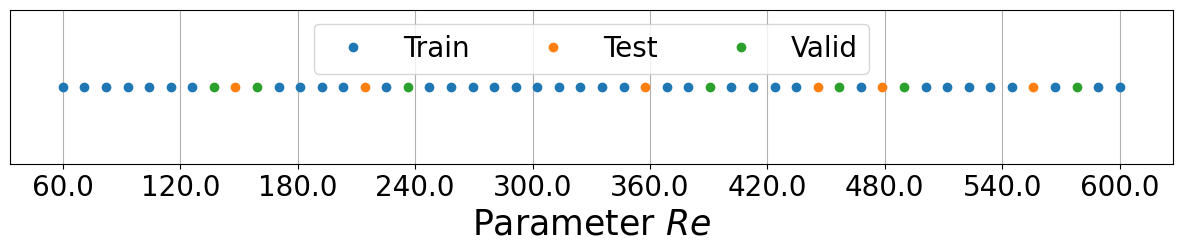

In [3]:
import matplotlib.pyplot as plt

ntrain = int(0.75 * Ns)

np.random.seed(5)
idx_train = np.random.choice(Ns, size = ntrain, replace = False)
mask = np.ones(Ns)
mask[idx_train] = 0
idx_valid_test = np.arange(0, Ns)[np.where(mask!=0)[0]]
idx_valid = idx_valid_test[::2]
idx_test = idx_valid_test[1::2]

nvalid = idx_valid.shape[0]
ntest = idx_test.shape[0]

print('Train:', ntrain, 'Valid:', nvalid, 'Test:', ntest)

idx_params = {
    'train': idx_train,
    'valid': idx_valid,
    'test': idx_test
}

fig, axs = plt.subplots(figsize=(15,2))

axs.plot(idx_train+1, np.ones_like(idx_train), 'o', label = 'Train')
axs.plot(idx_test+1,  np.ones_like(idx_test),  'o', label = 'Test')
axs.plot(idx_valid+1, np.ones_like(idx_valid), 'o', label = 'Valid')

axs.set_xlabel(r'Parameter $Re$', fontsize=25)
axs.set_xticks(np.linspace(1, len(params), 10), np.round(np.linspace(params.min(), params.max(), 10), 2))
axs.set_yticks([])
axs.grid()
axs.legend(ncols=3, loc='upper center', fontsize=20)
axs.tick_params(axis='x', labelsize=20)

Let us perform the SVD

In [4]:
from sklearn.utils.extmath import randomized_svd

modes = dict()
sing_vals = dict()

rank = 50

for field in var_names:
    print('Computing SVD for field:', field)
    X = snapshots[field][idx_train].reshape(-1, snapshots[field].shape[-1]).T
    U, S, _ = randomized_svd(X, n_components=rank, n_iter='auto')
    modes[field] = U
    sing_vals[field] = S

Computing SVD for field: p
Computing SVD for field: u


Let us plot the singular values

Text(0, 0.5, 'Relative Energy discarded')

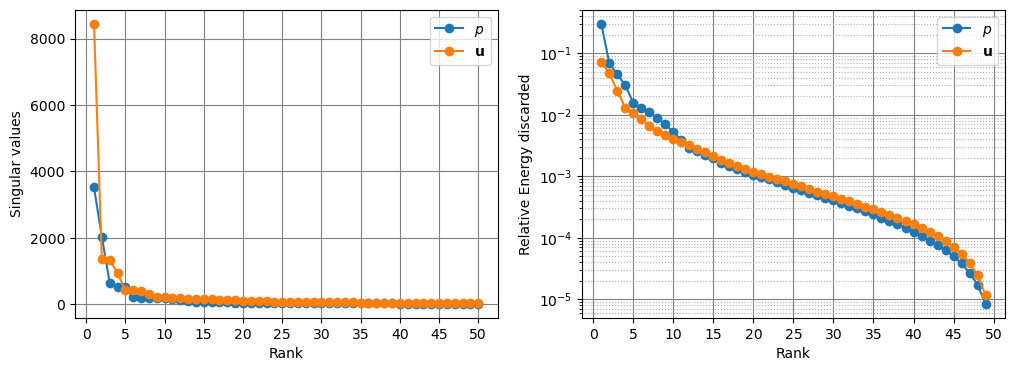

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

rank_plot = np.arange(1, rank+1)

for field_i, field in enumerate(var_names):
    axs[0].plot(rank_plot, sing_vals[field], 'o-', label=r'$'+tex_var_names[field_i]+'$')
    axs[1].semilogy(rank_plot[:-1], 1-np.cumsum(sing_vals[field][:-1] ** 2) / np.sum(sing_vals[field] ** 2), 'o-', label=r'$'+tex_var_names[field_i]+'$')

for ax in axs:
    ax.set_xlabel('Rank')
    ax.legend()
    ax.grid(which='major', linestyle='-', color='gray')
    ax.grid(which='minor', linestyle=':')
    ax.set_xticks(np.arange(0, rank+1, 5))

axs[0].set_ylabel('Singular values')
axs[1].set_ylabel('Relative Energy discarded')

Let us define a plot function and plot the modes

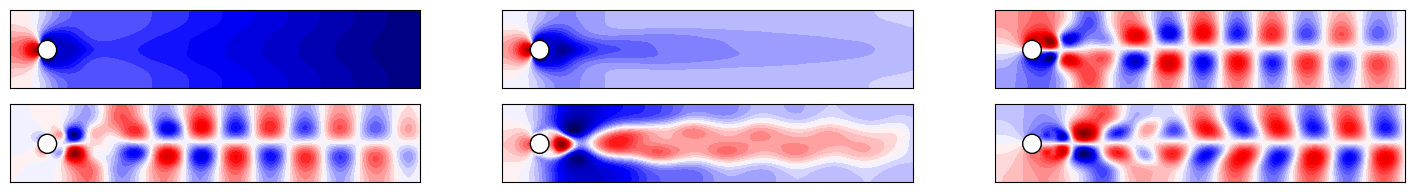

In [38]:
from matplotlib import cm, patches

def get_mag_fenicsx(u_vec):
    """
    Function to get the magnitude of a vector field in FEniCSx format (data are assumed 2D).
    """
    u = u_vec[0::2]
    v = u_vec[1::2]
    return np.sqrt(u**2 + v**2)


class PlotFlowCyl():
    
    def __init__(self, domain, centre = (0.2, 0.2), radius = 0.05):
        self.domain = domain

        width = np.max(domain[:,0]) - np.min(domain[:,0])
        height = np.max(domain[:,1]) - np.min(domain[:,1])

        self.aspect = height / width

        self.centre = centre
        self.radius = radius
    
    def create_circle(self, ls=1):
        
        circle = patches.Circle(self.centre, self.radius, edgecolor='black', facecolor='white', linewidth=ls)
        return circle
    
    def plot_contour(self, ax, snap, cmap = cm.RdYlBu_r, levels=40, show_ticks=False):

        if snap.shape[0] == 2*self.domain.shape[0]:
            snap = get_mag_fenicsx(snap)
            
        plot = ax.tricontourf(self.domain[:,0], self.domain[:,1], snap, cmap=cmap, levels=levels)
        ax.add_patch(self.create_circle())
        
        if not show_ticks:
            ax.set_xticks([])
            ax.set_yticks([])

        return plot
    
plotter = PlotFlowCyl(domain)

field_to_plot = 0
cmaps = [cm.seismic, cm.twilight]

nrows = 2
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows * plotter.aspect))
axs = axs.flatten()

for ii in range(nrows*ncols):
    plotter.plot_contour(axs[ii], modes[var_names[field_to_plot]][:, ii], cmap=cmaps[field_to_plot])


Let us compute the POD coefficients

In [10]:
pod_coeff = dict()

for field in var_names:
    pod_coeff[field] = dict()
    for key in idx_params.keys(): 
        pod_coeff[field][key] = np.zeros((len(idx_params[key]), Nt, rank))
        for mu_i in range(len(idx_params[key])):
            pod_coeff[field][key][mu_i] = np.dot(modes[field].T, snapshots[field][idx_params[key][mu_i]].reshape(-1, snapshots[field][idx_params[key][mu_i]].shape[-1]).T).T

## SHRED

### Compute Measures
The SHRED architecture takes as input M sensor measures and maps them to the reduced space characterizing the transient scenario. The sensor are placed randomly in the domain and measure the $x$-component of the velocity $u_x$
\begin{equation*}
y^{u_x}_m = v_m (u_x)\cdot(1+ \epsilon_m)
\end{equation*}
where $v_m$ is a functional describing the sensor procedure (either point-wise or Gaussian averaged) and $\epsilon_m$ is a Gaussian noise with standard deviation $\sigma$.

(-0.11000000000000001, 2.31, -0.020500000000000004, 0.43050000000000005)

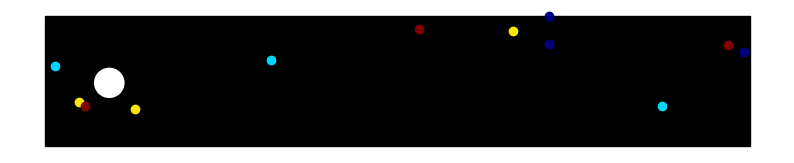

In [11]:
measured_field = 0

# Sampling the sensors locations
num_sensors = 3

n_configurations = 4
idx_sensor_locations = np.zeros((num_sensors, n_configurations), dtype=int)

np.random.seed(10) # For reproducibility
for kk in range(n_configurations):
    idx_sensor_locations[:, kk] = np.asarray(np.random.choice(Nh, size=num_sensors, replace=False), dtype=int)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
fig = plt.figure(figsize=(10, 10 * plotter.aspect ))
ax = fig.add_subplot()

rec = Rectangle((domain[:,0].min(), domain[:,1].min()), domain[:,0].max()-domain[:,0].min(), domain[:,1].max()-domain[:,1].min(), edgecolor='black', facecolor='black')
ax.add_patch(rec)

circ = plotter.create_circle()
ax.add_patch(circ)

sens_c = cm.jet(np.linspace(0, 1, n_configurations))
for kk in range(n_configurations):
    ax.scatter(domain[idx_sensor_locations[:, kk], 0], domain[idx_sensor_locations[:, kk], 1], color=sens_c[kk], label='Sensor %d' % (kk+1))

ax.axis('off')

Let us extract the measures

In [12]:
measurements = list()

for kk in range(n_configurations):

    measurements.append( dict() )

    for key in idx_params.keys():
        measurements[kk][key] = np.zeros((len(idx_params[key]), Nt, num_sensors))
        for mu_i in range(len(idx_params[key])):
            measurements[kk][key][mu_i] = snapshots[var_names[measured_field]][idx_params[key][mu_i], :, idx_sensor_locations[:, kk]].T

print('Sensors Shape')
print(measurements[0]['train'].shape)
print(measurements[0]['test'].shape)
print(measurements[0]['valid'].shape)

Sensors Shape
(37, 400, 3)
(6, 400, 3)
(7, 400, 3)


Let us add uncorrelated Gaussian noise to the measures

In [13]:
noise_value = 1.5e-1
Xsensor = list()

for kk in range(n_configurations):
    Xsensor.append({
        key: measurements[kk][key] * (1+np.random.normal(scale=noise_value, size=measurements[kk][key].shape))
        for key in list(measurements[kk].keys())
    })


print('Sensors Shape')
print(Xsensor[0]['train'].shape)
print(Xsensor[0]['test'].shape)
print(Xsensor[0]['valid'].shape)


Sensors Shape
(37, 400, 3)
(6, 400, 3)
(7, 400, 3)


Let us scale them to be in the range $[0, 1]$

In [14]:
from sklearn.preprocessing import MinMaxScaler

rescaled_Xsensor = list()
sens_scaler = list()
for kk in range(n_configurations):
    sens_scaler.append(MinMaxScaler())
    sens_scaler[kk].fit(Xsensor[kk]['train'].reshape(-1, num_sensors))

    rescaled_Xsensor.append({
        key: sens_scaler[kk].transform(Xsensor[kk][key].reshape(-1, num_sensors)).reshape(Xsensor[kk][key].shape)
        for key in list(Xsensor[kk].keys())
    })

Plotting some measures for a trajectory of the training set

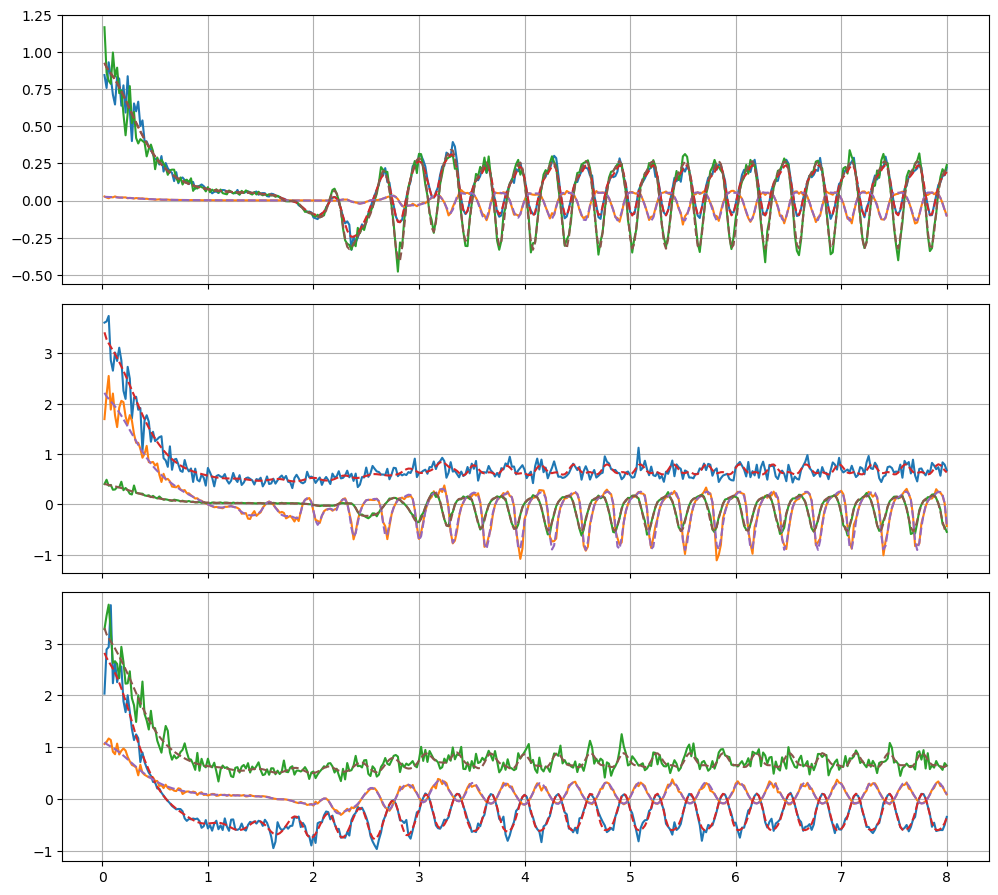

In [15]:
import matplotlib.pyplot as plt

ncols = 1
nrows = 3
fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, figsize= (10 * ncols, 3 * nrows))

if nrows == 1 and ncols == 1:
    axs = np.array([axs])

axs = axs.flatten()

param_to_plot = 0

for kk in range(nrows * ncols):
    axs[kk].plot(times, Xsensor[kk]['train'][param_to_plot])
    axs[kk].plot(times, measurements[kk]['train'][param_to_plot], '--')
    axs[kk].grid()
    
plt.tight_layout()

### Padding
In this section, the data are prepared to be fed into the SHRED architecture.

At first, let us load the POD coefficients and let us rescale them between 0 and 1.

In [16]:
Nmodes = [20]*len(var_names)

_stacked_POD_coeff = {
    key: np.concatenate([pod_coeff[var_names[field_i]][key][:, :, :Nmodes[field_i]] for field_i in range(len(var_names))], axis=-1)
    for key in list(pod_coeff[var_names[0]].keys())
}

vpod_scaler = MinMaxScaler()
vpod_scaler.fit(_stacked_POD_coeff['train'].reshape(-1, sum(Nmodes)))

rescaled_v_POD = {
    key: vpod_scaler.transform(_stacked_POD_coeff[key].reshape(-1, sum(Nmodes))).reshape(_stacked_POD_coeff[key].shape)
    for key in list(_stacked_POD_coeff.keys())
}

print('POD Coefficients Shape')
print(rescaled_v_POD['train'].shape)
print(rescaled_v_POD['test'].shape)
print(rescaled_v_POD['valid'].shape)

POD Coefficients Shape
(37, 400, 40)
(6, 400, 40)
(7, 400, 40)


Let us create the parameters data

In [17]:
mu = np.zeros((params.shape[0], len(times), 1))
for idx in range(params.shape[0]):
    mu[idx] = params[idx]

parameters = {
    key : mu[idx_params[key]]
    for key in list(idx_params.keys())
}

Nparams = 1
param_scaler = MinMaxScaler()
param_scaler.fit(parameters['train'].reshape(-1, Nparams))

rescaled_parameters = {
    key: param_scaler.transform(parameters[key].reshape(-1, Nparams)).reshape(parameters[key].shape)
    for key in list(parameters.keys())
}

print('Params Shape')
print(rescaled_parameters['train'].shape)
print(rescaled_parameters['test'].shape)
print(rescaled_parameters['valid'].shape)


Params Shape
(37, 400, 1)
(6, 400, 1)
(7, 400, 1)


### SHRED Training
Now, that we can all the ingredients to prepare the data for a SHRED approach: *SHRED is trained to predict the POD coefficients given 3 random measures*.

In [18]:
import sys
sys.path.append('/Users/sriva/Github/PublicRepo/NuSHRED')

from shred.processdata import Padding, TimeSeriesDataset, num2p, mre
import torch
from shred.models import SHRED, fit
import os

# GPU
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

Let us prepare them for the SHRED architecture.

In [19]:
lags = 30

# Input Data
train_data_in = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['train']), lags).to(device) for kk in range(n_configurations)]
valid_data_in = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['valid']), lags).to(device) for kk in range(n_configurations)]
test_data_in  = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['test']), lags).to(device)  for kk in range(n_configurations)]

# Output Data
train_data_out = [Padding(torch.cat((torch.from_numpy(rescaled_v_POD['train']), 
                                     torch.from_numpy(rescaled_parameters['train'])), 
                                     axis=2), 1).squeeze(1).to(device)
                                     for kk in range(n_configurations)]

valid_data_out = [Padding(torch.cat((torch.from_numpy(rescaled_v_POD['valid']), 
                                     torch.from_numpy(rescaled_parameters['valid'])), 
                                     axis=2), 1).squeeze(1).to(device)
                                     for kk in range(n_configurations)]

test_data_out = Padding(torch.cat((torch.from_numpy(rescaled_v_POD['test']), 
                                     torch.from_numpy(rescaled_parameters['test'])), 
                                     axis=2), 1).squeeze(1).to(device)

output_size = test_data_out.shape[-1]

# Create Dataset for SHRED training
train_dataset = [TimeSeriesDataset(train_data_in[kk], train_data_out[kk]) for kk in range(n_configurations)]
valid_dataset = [TimeSeriesDataset(valid_data_in[kk], valid_data_out[kk]) for kk in range(n_configurations)]
test_dataset  = [TimeSeriesDataset(test_data_in[kk],  test_data_out)  for kk in range(n_configurations)]

Let us train the SHRED models for each configuration

In [20]:
import time
import pickle

path_shred = f'./Results/SHREDparametric_rank{sum(Nmodes)}/'
os.makedirs(path_shred, exist_ok=True)

train_net = False

shred = list()

if train_net:
    comp_times = list() 
# else:
    # comp_times = pickle.load(open(path_shred+'comp_times.pkl', 'rb'))
for kk in range(n_configurations):
    
    shred.append(SHRED( num_sensors, output_size, 
                        hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device))
    
    print('Training SHRED - configuration '+str(kk+1)+'/'+str(n_configurations))
    
    if train_net:
        start = time.time()

        fitting_errors = fit(   shred[kk], train_dataset[kk], valid_dataset[kk], 
                                batch_size = 64, epochs = 3000, lr = 1e-3, verbose = True, patience = 75)

        shred[kk].freeze()
        torch.save(shred[kk].state_dict(), path_shred+'trained_config'+str(kk)+'_measuring_'+str(num_sensors)+'.shred')
        
        comp_times.append(time.time()-start)

        print(' ')
    else:
        shred[kk].load_state_dict(torch.load(path_shred+'trained_config'+str(kk)+'_measuring_'+str(num_sensors)+'.shred',
                                             map_location=device))
        shred[kk].freeze()

if train_net:
    pickle.dump(comp_times, open(path_shred+'comp_times.pkl', 'wb'))
    

Training SHRED - configuration 1/4
Training SHRED - configuration 2/4
Training SHRED - configuration 3/4
Training SHRED - configuration 4/4


Checking the test errors on the POD coefficients

In [22]:
Ytest_POD_hat = torch.stack([shred[kk](test_dataset[kk].X) for kk in range(n_configurations)], dim=0)

Ytest_POD_pred = {
    'mean': Ytest_POD_hat.mean(axis=0)[:, :sum(Nmodes)],
    'std':  Ytest_POD_hat.std(axis=0)[:,  :sum(Nmodes)] / np.sqrt(n_configurations)
}

# The test data are independent on the configurations of the sensors
print("Mean relative SHRED prediction error on POD coeffs: %s." % num2p(mre(test_dataset[0].Y[:, :sum(Nmodes)],
                                                                            Ytest_POD_pred['mean'])))
print("Std  relative SHRED prediction error on POD coeffs: %s." % num2p((Ytest_POD_pred['std'].pow(2).sum(axis = -1).sqrt() / (test_dataset[0].Y[:, :sum(Nmodes)]).pow(2).sum(axis = -1).sqrt()).mean()))

Mean relative SHRED prediction error on POD coeffs: 5.31%.
Std  relative SHRED prediction error on POD coeffs: 4.53%.


Let us plot the errors on each POD coefficient

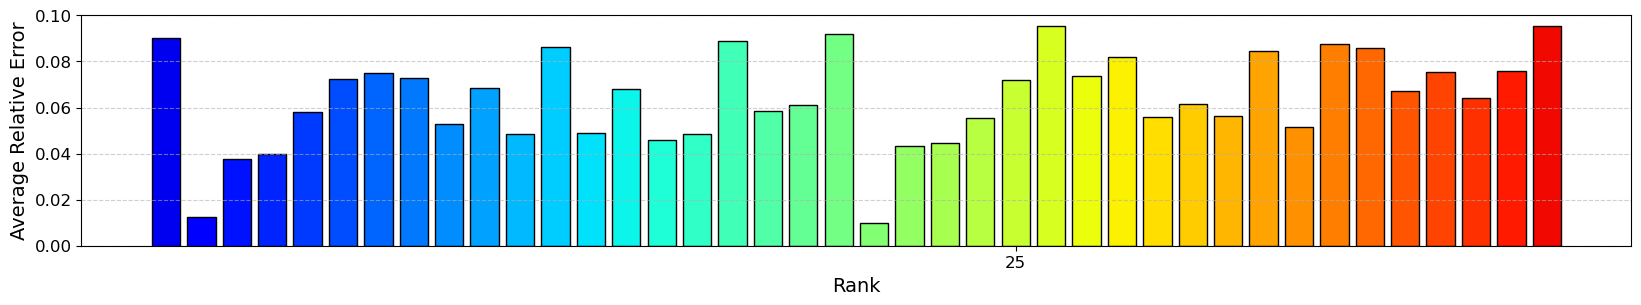

In [23]:
errors_per_coeff = {
    'mean': [(mre(Ytest_POD_pred['mean'][:, rr], test_dataset[0].Y[:, rr])).item() for rr in range(sum(Nmodes))],
    'std':  [((Ytest_POD_pred['std'][:, rr].pow(2).sum(axis = -1).sqrt() / (test_dataset[0].Y[:, rr].pow(2).sum(axis = -1).sqrt()).mean())).item() for rr in range(sum(Nmodes))]
}

# Bar positions
indices = np.arange(len(errors_per_coeff['mean']))+1

# Colormap
cmap = plt.cm.jet
colors = cmap(np.linspace(0.1, 0.9, len(errors_per_coeff['mean'])))

# Plot
fig, ax = plt.subplots(figsize=(20, 3))
bars = ax.bar(indices, errors_per_coeff['mean'], capsize=5, color=colors, edgecolor='black')

# Labels and formatting
ax.set_xlabel("Rank", fontsize=14)
ax.set_ylabel("Average Relative Error", fontsize=14)
ax.set_xticks(indices[24::25])
ax.set_xticklabels([f"{i}" for i in indices[24::25]], fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.6)


### Reconstruction of the Latent Dynamics

Let us reshape the output of the SHRED models and the associated test data to simplify the access to the variables.

In fact, the output of the SHRED models is a 2D array with dimensions $N_p^{test}\cdot N_t \times (R+N_{params})$, given $N_p$ the number of elements in the parameter test set, $N_t$ the number of time steps, $R$ the number of total rank of the latent space and $N_{params}$ the number of parameters (only 1, since $\tau$ only has been considered).

In [24]:
reshaped_test_POD_out = test_dataset[0].Y[:, :sum(Nmodes)].cpu().detach().numpy().reshape(len(idx_params['test']), Nt, sum(Nmodes))

reshaped_POD_test_out_pred = {
    'mean': Ytest_POD_pred['mean'][:, :sum(Nmodes)].cpu().detach().numpy().reshape(len(idx_params['test']), Nt, sum(Nmodes)),
    'std':  Ytest_POD_pred['std'][:, :sum(Nmodes)].cpu().detach().numpy().reshape(len(idx_params['test']), Nt, sum(Nmodes))
}

Let us compare the POD coefficients (first 5 modes)

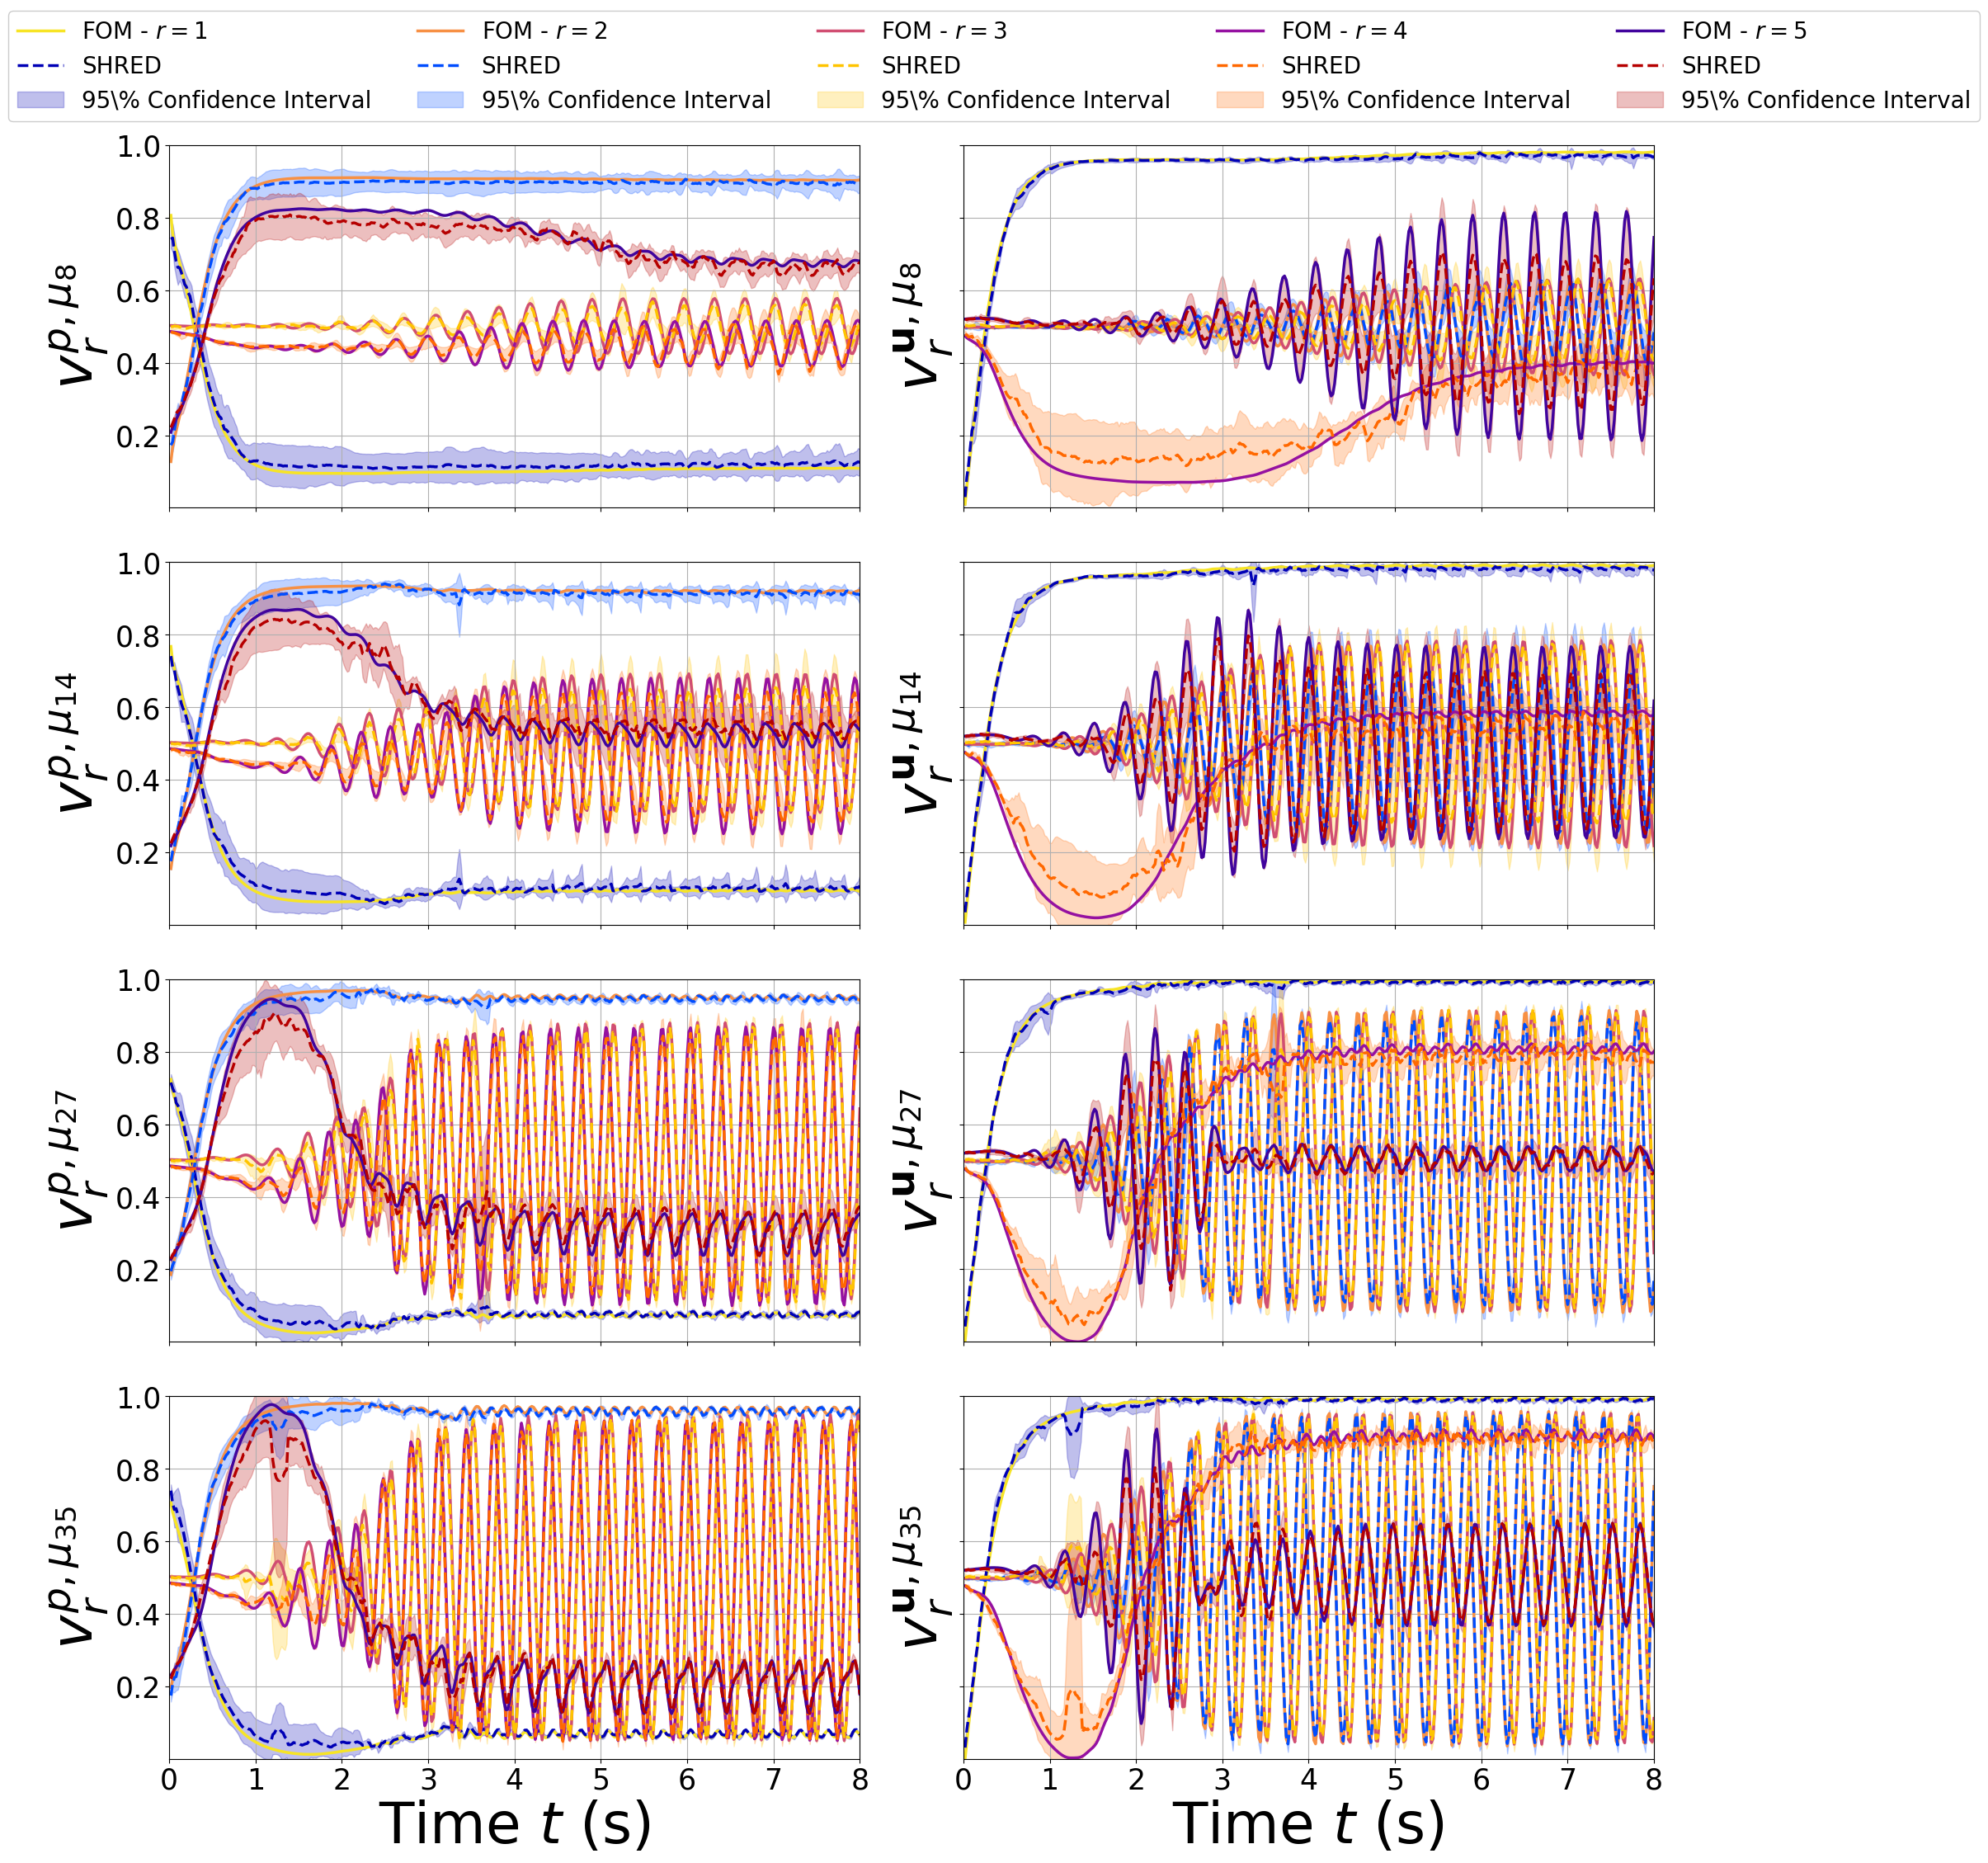

In [25]:
modes_to_plot = 5
param_to_plot = np.random.choice(np.arange(reshaped_test_POD_out.shape[0]), size=4, replace=False)

nrows = len(param_to_plot)
ncols = len(var_names)
fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, sharey=True, figsize=(10 * ncols, 6 * nrows))

ls = 2.5

for pp in range(nrows):

    for field_i, field in enumerate(var_names):

        idx_to_plot = np.arange(sum(Nmodes[:field_i]),
                                modes_to_plot + sum(Nmodes[:field_i]),
                                1, 
                                dtype=int)

        colors = cm.jet([0.05, 0.2, 0.7, 0.8, 0.95])
        colors_gt = cm.plasma(np.linspace(0.1,0.95,len(idx_to_plot)))

        for ii, idx in enumerate(idx_to_plot):
            axs[pp, field_i].plot(times, reshaped_test_POD_out[pp,:,idx],
                            '-', linewidth=ls, c=colors_gt[-1-ii], label=r'FOM - $r='+str(ii+1)+'$')
            axs[pp, field_i].plot(times, reshaped_POD_test_out_pred['mean'][pp,:,idx],
                            '--', c=colors[ii], label=r'SHRED', linewidth=ls)
            axs[pp, field_i].fill_between(times,
                                        y1 = reshaped_POD_test_out_pred['mean'][pp,:,idx] - 1.96 * reshaped_POD_test_out_pred['std'][pp,:,idx],
                                        y2 = reshaped_POD_test_out_pred['mean'][pp,:,idx] + 1.96 * reshaped_POD_test_out_pred['std'][pp,:,idx],
                                        color=colors[ii], alpha=0.25, label=r'95\% Confidence Interval')

        axs[pp, field_i].set_ylabel(r'$v_r^{'+tex_var_names[field_i]+r', \boldsymbol{{\mu}}_{'+str(idx_params['test'][pp])+'}}$', fontsize=50)
        axs[pp, field_i].grid()

        axs[pp, field_i].set_ylim(reshaped_test_POD_out[:,:,idx_to_plot].min(), 
                            reshaped_test_POD_out[:,:,idx_to_plot].max())
        axs[pp, field_i].set_xlim(0, times[-1])
        axs[pp, field_i].tick_params(axis='both', labelsize=25)
        
Line, Label = axs[0,0].get_legend_handles_labels()
fig.legend(Line, Label, fontsize=20, ncols=5, framealpha=1, loc='upper center')

[ax.set_xlabel(r'Time $t$ (s)', fontsize=50) for ax in axs[-1]]

fig.subplots_adjust(left=0, hspace=0.15, top = 0.925, wspace=0.15)
fig.savefig(path_shred+'LatentDynamics.pdf', bbox_inches='tight', dpi=300)

## Project back to the high-dimensional space
The SHRED architecture is trained to predict the POD coefficients given the sensor measures. The POD coefficients are then used to reconstruct the high-dimensional state.

The error is computed using the Euclidian norm

In [26]:
from tqdm import tqdm
from IPython.display import clear_output as clc

ave_rel_errors = {
    'mean': np.zeros((len(var_names), len(idx_params['test']), Nt)),
    'std' : np.zeros((len(var_names), len(idx_params['test']), Nt))
}

for field_i in range(len(var_names)):
    field = var_names[field_i]
    idx_to_rec = np.arange(sum(Nmodes[:field_i]),  sum(Nmodes[:field_i+1]),  1, dtype=int)

    for pp in tqdm(range(len(idx_params['test'])), 'Computing error for '+field):
        param_to_recon = idx_params['test'][pp]
        fom = snapshots[field][param_to_recon].T

        _tmp_mean_v = vpod_scaler.inverse_transform(reshaped_POD_test_out_pred['mean'].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out_pred['mean'].shape)
        _tmp_std_v  = vpod_scaler.inverse_transform(reshaped_POD_test_out_pred['std'].reshape( -1, sum(Nmodes))).reshape(reshaped_POD_test_out_pred['std'].shape) - vpod_scaler.data_min_

        recon     = modes[field][:, :Nmodes[field_i]] @ _tmp_mean_v[pp, :, idx_to_rec]
        std_recon = modes[field][:, :Nmodes[field_i]] @ _tmp_std_v[ pp, :, idx_to_rec]

        ave_rel_errors['mean'][field_i, pp] = np.linalg.norm(fom - recon, axis=0) / np.linalg.norm(fom, axis=0)
        ave_rel_errors['std'][field_i, pp]  = np.linalg.norm(std_recon, axis=0)   / np.linalg.norm(fom, axis=0)

        del fom, recon, std_recon
    clc()

Let us plot the errors using bar plots

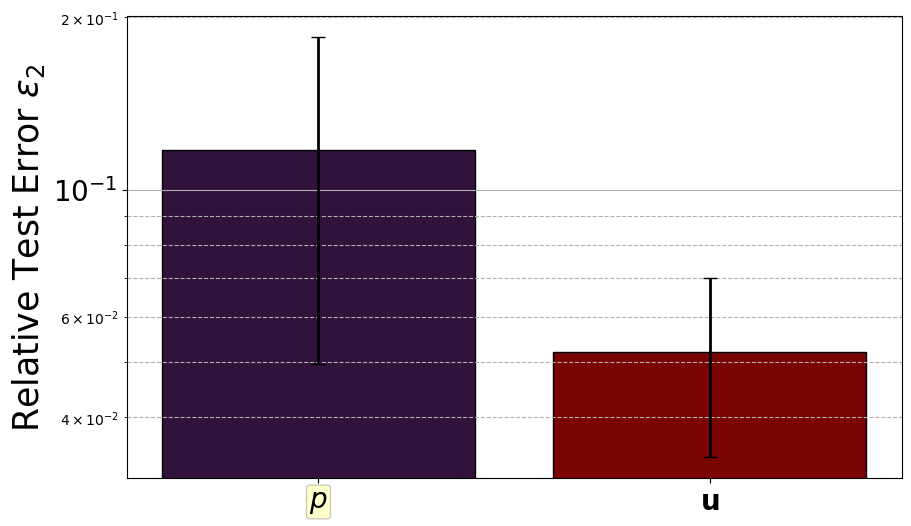

In [27]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(10,6))

colors = cm.turbo(np.linspace(0,1, len(var_names)))
axs.bar(np.arange(1, len(var_names)+1, 1), ave_rel_errors['mean'].mean(axis=2).mean(axis=1), 
        yerr = ave_rel_errors['mean'].mean(axis=1).std(axis=1), capsize=5,
        color = colors,
        edgecolor='black',error_kw={'elinewidth': 2, 'ecolor': 'black', 'capsize': 5})

axs.set_yscale('log')
axs.set_xticks(np.arange(1,len(var_names)+1,1), ['$'+tex_+'$' for tex_ in tex_var_names])
# axs.set_yticks(np.arange(0,0.1,0.01))

axs.tick_params(axis='both', labelsize=20)
axs.set_ylabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=25)
axs.grid(axis='y', linestyle='-')
axs.grid(axis='y', which='minor', linestyle='--')

xticks = axs.get_xticklabels()
xticks[measured_field].set_color('black') 
xticks[measured_field].set_bbox(dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.1', alpha=0.2))


### Contour plots
Let us plot the contour plots of the pressure and velocity field at different time steps

In [36]:
import matplotlib.ticker as mticker

ncols = len(var_names)  # Swap rows and columns
nrows = 4

param_to_plot = 5 # np.random.choice(np.arange(reshaped_test_POD_out.shape[0]), size=1, replace=False)[0]

import os
path_figs = path_shred+'Figs_mu_'+str(param_to_plot)+'/'
os.makedirs(path_figs, exist_ok=True)

levels = [np.linspace(-2, 4, 60), np.linspace(0, 2.5, 60)]
cmaps_std = [cm.viridis, cm.viridis]

save_fig = True

fontsize=15

sampling = 10

for tt in range(sampling - 1, Nt, sampling):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 8 * nrows * plotter.aspect))

    for field_i, field in enumerate(var_names):
        fom = snapshots[field][idx_params['test'][param_to_plot], tt].T
        idx_to_rec = np.arange(sum(Nmodes[:field_i]), sum(Nmodes[:field_i + 1]), 1, dtype=int)

        _tmp_mean_v = vpod_scaler.inverse_transform(reshaped_POD_test_out_pred['mean'].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out_pred['mean'].shape)
        _tmp_std_v = vpod_scaler.inverse_transform(reshaped_POD_test_out_pred['std'].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out_pred['std'].shape) - vpod_scaler.data_min_

        recon = modes[field][:, :Nmodes[field_i]] @ _tmp_mean_v[param_to_plot, tt, idx_to_rec]
        std_recon = modes[field][:, :Nmodes[field_i]] @ _tmp_std_v[param_to_plot, tt, idx_to_rec]
        residual = fom - recon #np.abs(fom - recon)

        fom_cont = plotter.plot_contour(axs[0, field_i], fom, cmap=cmaps[field_i], levels=levels[field_i])
        plotter.plot_contour(axs[1, field_i], recon, cmap=cmaps[field_i], levels=levels[field_i])
        std_cont = plotter.plot_contour(axs[3, field_i], std_recon, cmap=cmaps_std[field_i], levels=40)
        res_cont = plotter.plot_contour(axs[2, field_i], residual, cmap=cmaps[field_i], levels=levels[field_i])

        axs[0, field_i].set_title(r'$' + tex_var_names[field_i] + '$', fontsize=20)

        # Create colorbars with increased thickness and controlled tick labels
        formatter = mticker.FuncFormatter(lambda x, _: f"{x:.2f}")

        cbar1 = fig.colorbar(fom_cont, ax=axs[0, field_i], orientation='vertical', pad=0.05, fraction=0.08, aspect=5)
        cbar1.locator = mticker.MaxNLocator(nbins=5)
        cbar1.formatter = formatter
        cbar1.ax.tick_params(labelsize=fontsize)
        cbar1.update_ticks()

        cbar2 = fig.colorbar(fom_cont, ax=axs[1, field_i], orientation='vertical', pad=0.05, fraction=0.08, aspect=5)
        cbar2.locator = mticker.MaxNLocator(nbins=5)
        cbar2.formatter = formatter
        cbar2.ax.tick_params(labelsize=fontsize)
        cbar2.update_ticks()

        cbar3 = fig.colorbar(std_cont, ax=axs[3, field_i], orientation='vertical', pad=0.05, shrink=0.9, fraction=0.08, aspect=5)
        cbar3.locator = mticker.MaxNLocator(nbins=5)
        cbar3.formatter = formatter
        cbar3.ax.tick_params(labelsize=fontsize)
        cbar3.update_ticks()

        cbar4 = fig.colorbar(res_cont, ax=axs[2, field_i], orientation='vertical', pad=0.05, fraction=0.08, aspect=5)
        cbar4.locator = mticker.MaxNLocator(nbins=5)
        cbar4.formatter = formatter
        cbar4.ax.tick_params(labelsize=fontsize)
        cbar4.update_ticks()

    axs[0, 0].set_ylabel('FOM', fontsize=fontsize)
    axs[1, 0].set_ylabel('SHRED Mean', fontsize=fontsize)
    axs[3, 0].set_ylabel('SHRED Std', fontsize=fontsize)
    axs[2, 0].set_ylabel('Residual', fontsize=fontsize)

    fig.text(0.5, 0.01, f'Time $t = {times[tt]:.2f}$ s - $Re = {params[idx_params["test"][param_to_plot]][0]:.2f}$', ha='center', fontsize=fontsize+10)

    fig.subplots_adjust(wspace=0.075, bottom=0.1)

    if save_fig:
        fig.savefig(f'{path_figs}FlowOverCyl_{tt}.png', dpi=100, bbox_inches='tight')
    else:
        plt.show()
        clc(wait=True)
    plt.close(fig)



Let us create a gif of the contour plots.

In [39]:
import imageio.v2 as imageio

# Create the GIF by loading each image and adding it to the array
def create_gif(gif_path, path_imgs, image_files, duration=150.):
    with imageio.get_writer(gif_path, mode='I', duration=duration, loop=0) as writer:
        for img_file in image_files:
            img_path = os.path.join(path_imgs, img_file)
            image = imageio.imread(img_path)
            writer.append_data(image)

if save_fig:

    image_files = sorted(os.listdir(path_figs), key=lambda x: int(x.split('_')[-1].split('.')[0]))

    path_gif = 'Media/'
    os.makedirs(path_gif, exist_ok=True)
    create_gif(path_gif+f'OnlineParametric.gif', path_figs, image_files, duration=160.)